# Implementing Deep Q-Learning with Experience Replay

Based on Playing Atari with Deep Reinforcement Learning [link](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

Main aim is to train a *policy* that tries to maximise $R_{t_0} = \sum_{t=t_0}^{\inf}\gamma^{t-t_0}r_t$ (the discounted cumulative reward) with the discount $0 < \gamma < 1$

**Q-learning** in particular assumes the existence of a function $Q^\star: \text{State}\times\text{Action}\rightarrow \mathbb{R}$ that approximates the return given a state and an action.

Hence, one can construct a policy that maximises the expected reward: $\pi^\star(s)=\text{argmax}_aQ^\star(s, a)$

We initialise this **Q-table** and then update it at each training step as so: $Q^\pi(s,a)=r + \gamma Q^\pi(s', \pi(s'))$

Define the temporal difference error $\delta$ as $\delta = Q(s, a) - (r + \gamma \text{max}_aQ(s',a))$

Minimise error using *Huber loss*, so $\mathcal{L} = \frac{1}{|B|}_{(s, a, s', r)\in B}\sum \mathcal{L}(\delta)$ where $\mathcal{L}(\delta) = \frac{1}{2}\delta^2$ if $\delta|\leq 1$ or $|\delta| - \frac{1}{2}$ otherwise.

---
### Includes

In [1]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from envs.dsdp import DiscreteStochasticDecisionProcess

env = DiscreteStochasticDecisionProcess()

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

---
### Helper functions

In [2]:
def plot_durations():
    fig, axs = plt.subplots(2)
    
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    visits_t = [(x[0], torch.tensor(x[1], dtype=torch.float)) for x in state_visits.items()]
    
    fig.suptitle('Training')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('State Visits')
    
    axs[0].plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 10:
        means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        axs[0].plot(means.numpy())
    
    if len(durations_t) >= 100:
        for t in visits_t:
            means = t[1].unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            axs[1].plot(means.numpy(), label=f"State {t[0] + 1}")
            axs[1].legend()
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

---
### Code

In [3]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*random.sample(self.memory, batch_size))
        state_batch = np.concatenate(state_batch, axis=0)
        action_batch = np.array(action_batch)
        next_state_batch = np.concatenate(next_state_batch, axis=0)
        reward_batch = np.array(reward_batch)
        done_batch = np.array(done_batch)
        return state_batch, action_batch, next_state_batch, reward_batch, done_batch

    def __len__(self):
        return len(self.memory)

In [4]:
BATCH_SIZE = 128
GAMMA = 1.0

def one_hot(n, v):
    a = np.zeros(n)
    a[v] = 1.0
    return np.expand_dims(a, axis=0)

def rev_one_hot(a):
    return np.where(a[0] > 0)[0][0]

class DQN(nn.Module):
    def __init__(self, inputs, outputs, mem_len = 10000):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.head = nn.Linear(128, outputs)
        
        self.memory = ReplayMemory(mem_len)
        self.optimizer = None
        
        self.n_actions = outputs
        self.steps_done = 0
        
        self.EPS_START = 1
        self.EPS_END = 0.1
        self.EPS_DECAY = 50000 # in number of steps

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x)
    
    def act(self, state):
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * (1. - min(1., self.steps_done / self.EPS_DECAY))
        self.steps_done += 1

        # With probability eps select a random action
        if random.random() < eps_threshold:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return self(state).max(1)[1].view(1, 1)
    
    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        # in the form (state, action) -> (next_state, reward, done)
        state_batch, action_batch, next_state_batch, reward_batch, done_mask = self.memory.sample(BATCH_SIZE)
        
        state_batch = torch.from_numpy(state_batch).float()
        action_batch = torch.from_numpy(action_batch).long()
        next_state_batch = torch.from_numpy(next_state_batch).float()
        reward_batch = torch.from_numpy(reward_batch).float()
        not_done_mask = torch.from_numpy(1 - done_mask).float()
        
        current_Q_values = self(state_batch).gather(1, action_batch.unsqueeze(1))
        # Compute next Q value based on which goal gives max Q values
        # Detach variable from the current graph since we don't want gradients for next Q to propagated
        next_max_q = self(next_state_batch).detach().max(1)[0]
        next_Q_values = not_done_mask * next_max_q
        # Compute the target of the current Q values
        target_Q_values = reward_batch + (GAMMA * next_Q_values)
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
            
class HDQN(nn.Module):
    def __init__(self, n_observations, n_goals, n_actions):
        super(HDQN, self).__init__()
        # Optimizer
        learning_rate = 2.5e-4
        
        self.meta_controller = DQN(n_observations, n_goals).to(device)
        self.meta_controller.optimizer = optim.RMSprop(self.meta_controller.parameters(), lr=learning_rate)
        self.controller = DQN(n_goals + n_observations, n_actions).to(device)
        self.controller.optimizer = optim.RMSprop(self.controller.parameters(), lr=learning_rate)
        
        self.n_observations = n_observations
        self.n_goals = n_goals
        self.n_actions = n_actions
    
    def store_controller(self, *args):
        self.controller.memory.store(*args)
    
    def store_meta_controller(self, *args):
        self.meta_controller.memory.store(*args)
    
    def select_goal(self, external_observation):
        return self.meta_controller.act(external_observation)
        
    def select_action(self, joint_goal_obs):
        return self.controller.act(joint_goal_obs)
    
    def intrinsic_reward(self, goal, state):
        if goal == state:
            return 1.0
        return 0.0
    
    def experience_replay(self):
        self.meta_controller.experience_replay()
        self.controller.experience_replay()

Complete


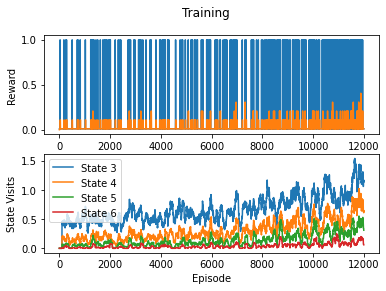

In [6]:
# Get number of actions and observations from gym action space
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

# Initialize action-value function Q with random weights
hdqnAgent = HDQN(n_observations, n_observations, n_actions).to(device)

num_episodes = 12000 # M
episode_durations = []
state_visits = {2: [], 3: [], 4: [], 5: []}

for i_episode in range(num_episodes):
    observation = env.reset()
    state = torch.from_numpy(observation).float()
    
    overall_reward = 0
    ep_state_visits = {2: 0, 3: 0, 4: 0, 5: 0}
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        encoded_goal = one_hot(n_observations, [goal.item()])
        
        goal_done = False
        total_extrinsic = 0
        s_0 = state
        while not done and not goal_done:
            
            joint_goal_state = torch.from_numpy(np.concatenate([encoded_goal, state], axis=1)).float()
            
            # Execute action a_t in emulator and observe reward r_t and image x_{t+1}
            action = hdqnAgent.select_action(joint_goal_state)
            
            observation, reward, done, _ = env.step(action.item())
            extrinsic_reward = torch.tensor([reward], device=device)
            
            decoded_obs = rev_one_hot(observation)

            if decoded_obs in ep_state_visits.keys():
                ep_state_visits[decoded_obs] += 1
            
            overall_reward += reward
            total_extrinsic += reward
            
            intrinsic_reward = torch.tensor([hdqnAgent.intrinsic_reward(goal, decoded_obs)], device=device)

            # preprocess φ_{t+1} = φ(s_{t+1})
            next_state = torch.from_numpy(observation).float()
            joint_next_state = torch.from_numpy(np.concatenate([encoded_goal, next_state], axis=1)).float()

            goal_done = (decoded_obs == goal)
                
            # Store transition (φt, at, rt, φt+1) in D
            hdqnAgent.store_controller(joint_goal_state, action, joint_next_state, intrinsic_reward, done)

            state = next_state

            hdqnAgent.experience_replay()
            
        # Store transition for meta controller
        hdqnAgent.store_meta_controller(s_0, goal, next_state, torch.tensor([total_extrinsic], device=device), done)
        hdqnAgent.experience_replay()
        
    episode_durations.append(overall_reward)
    for i in ep_state_visits.keys():
        state_visits[i].append(ep_state_visits[i])
    plot_durations()

print('Complete')
plot_durations()

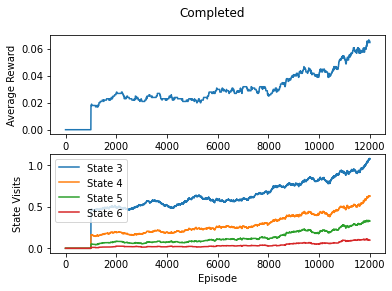

In [7]:
def plot_durations2():
    fig, axs = plt.subplots(2)
    
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    visits_t = [(x[0], torch.tensor(x[1], dtype=torch.float)) for x in state_visits.items()]
    
    fig.suptitle('Completed')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Average Reward')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('State Visits')
    
    #axs[0].plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 1000:
        means = durations_t.unfold(0, 1000, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(999), means))
        axs[0].plot(means.numpy())
    
    if len(durations_t) >= 1000:
        for t in visits_t:
            means = t[1].unfold(0, 1000, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(999), means))
            axs[1].plot(means.numpy(), label=f"State {t[0] + 1}")
            axs[1].legend()
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
plot_durations2()